In [2]:
from framework_pkg.framework import FrameWork

import numpy as np
import matplotlib.pyplot as plt
from scipy import interpolate
from cobaya.run import run

from getdist.mcsamples import MCSamplesFromCobaya
from getdist import plots, MCSamples
import getdist.plots as gdplt

from getdist import loadMCSamples

import warnings
warnings.filterwarnings('ignore')

plt.rcParams['text.usetex']=True
plt.style.use('classic')


In [3]:
param ={'SinT12'  : 0.308 ,
        'T13'  : 8.57, 
        'mu1'  : 0.,
        'mu2'  : 0., 
        'mu3'  : 0.  ,
        'mdm'  : 9.02e-4 , 
        'alpha': 0.  ,
        'eps' : 0.  ,
        'alpha_eps' : 0.  ,
        'M12'  : 6.9e-5 }


frame_predicted_total_signal  = FrameWork(add= './Data/time_exposures.txt', threshold=4.5, lat=36,
                                        efficiency_correction=True,
                                        resolution_correction=False,
                                    )

data = np.loadtxt('./Data/modulation_data.txt')
time_bins = np.unique(frame_predicted_total_signal.time_day[:,0])
sigma_p = 0.014
mean_data = np.mean(data[:,1])

In [4]:
def LogLikelihood(sint12, m12, mdm, mu2, alpha, eps, alpha_eps, delta_p):
    param['SinT12'] = sint12
    param['M12'] = m12 * 1e-5

    param['mu2'] = mu2
    param['alpha'] = alpha
    param['eps'] = eps
    param['alpha_eps'] = alpha_eps

    param['mdm'] = mdm * 2e-4

    signal_fraction = frame_predicted_total_signal.__getitem__(param) 
    daily_exposure, R_daily = frame_predicted_total_signal._result_daily_basis(signal_fraction)

    bin_prediction = np.zeros((len(time_bins)))
    for i in range(len(time_bins)):
        cond = frame_predicted_total_signal.time_day[:,0] == time_bins[i]
        bin_prediction[i] = (1/np.sum(daily_exposure[cond])) * np.sum(5.25 * daily_exposure[cond] * R_daily[cond,0])
        
    prediction = bin_prediction * ( 1 - delta_p * sigma_p)
    prediction = prediction - np.mean(prediction)

    cond1 = data[:,1] - mean_data >= prediction
    cond2 = data[:,1] - mean_data < prediction
    lower_part  = (data[cond1,1] - mean_data - prediction[cond1])**2 / data[cond1,3]**2
    upper_part = (data[cond2,1] - mean_data - prediction[cond2])**2 / data[cond2,2]**2

    return -0.5 * ( np.sum(lower_part) + np.sum(upper_part) + delta_p**2 ) 

In [5]:
print(LogLikelihood(0.308, 7.22, 4.97, 0., 0., 0., 0., 0.))

-422.81343886124307


In [6]:
info = {"likelihood": {"Chi2": LogLikelihood},
        
        "params": dict([("sint12" , {"prior" : {"min": 0.275, "max": 0.345},
                                  "latex" : r"\sin(\theta_{12})^2"  
                                  }),

                        
                        ("m12"    , {"prior" : {"min": 6.92, "max": 8.05},
                                  "latex": r"\Delta m^2_{21} \ \rm 10^{-5} \ eV^2"  
                                  }), 
                        
                        ("mu2"    , {"prior" : {"min": 0, "max": 0.25},
                                   "latex" : r"\tilde{\mu}^2/2 "  
                                   }),
                        
                        ("alpha"  , {"prior" : {"min": 0, "max": np.pi},
                                   "latex" : r"\alpha "  
                                   }),
                        
                        ("eps"  , {"prior" : {"min": 0, "max": 1.},
                                   "latex" : r"\epsilon "  
                                   }),

                        ("alpha_eps"  , {"prior" : {"min": 0, "max": np.pi},
                                   "latex" : r"\alpha_\epsilon "  
                                   }), 

                        ("delta_p", {"prior" : {"min": -3, "max": 3},
                                  "latex": r"\delta_p"  
                                  }) ,

                        ("mdm", {"prior" : {"min": 1, "max": 10},
                                   "latex": r"m_{\rm dm}"  
                                  }) 
                        
                        ]),
        
        "sampler": {"mcmc": {"Rminus1_stop": 0.01, "max_tries": 100000 }},
        "output" : "output8/run_info"
       }

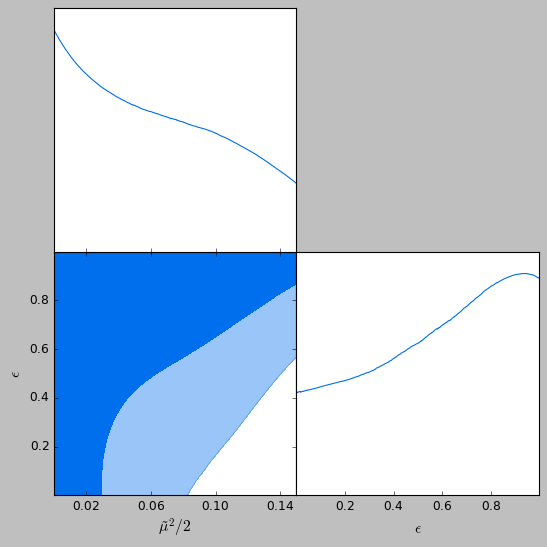

In [68]:
# Filled 2D comparison plot with legend
#gd_sample = MCSamplesFromCobaya(updated_info, sampler.products()["sample"])


# Path to your Cobaya output folder (replace with your actual path)
output_folder = "output10_1/run_info"

# Load the MCMC samples
samples = loadMCSamples(output_folder)

# param_names = samples.getParamNames()

# print("Current labels:", [p.label for p in param_names.names])

# # print("Parameter names:", param_names.names)
# # print("LaTeX labels:", param_names.labels)

# # Fix a specific parameter's LaTeX label (e.g., replace "omegab" with correct LaTeX)
# param_names.setLabels({"mu2" :  "\tilde{\mu}^2/2 "} )
    
# print( param_names.parWithName("mu2").label)



# param_names = samples.getParamNames().names
# for p in param_names:
#     if p.name == "mu2":
#         p.label = r"\tilde{\mu}^2/2 "

gdplot = gdplt.get_subplot_plotter(width_inch=7)

gdplot.settings.scaling = False
# gdplot.triangle_plot(samples, ["sint12","m12","mu2", "alpha", "delta_p"], filled=True, 
#                      param_limits={'t12': (0.28, 0.36), 
#                                    'm12': (7, 8),
#                                    'delta': (-0.2, 0.2),
#                                    'mum2': (0, 1.5)
#                                   },lw=2)


gdplot.triangle_plot(samples, ["mu2", "eps"], filled=True,lw=2)
#gdplot.triangle_plot(samples, ["mu2", "alpha","eps","alpha_eps"], filled=True, 
#                    lw=2)

# gdplot.export('./bayes_1_nopriors.pdf')

[ 0.31312049  7.52434951  0.06339196  0.57303446 -0.27749321 -3.37897289
 -3.37897289  2.01520197  2.01520197]


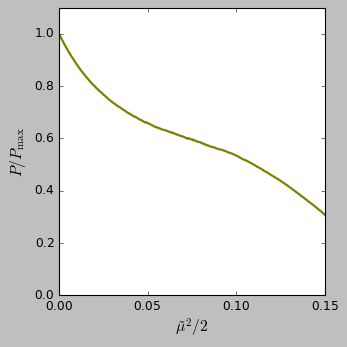

In [63]:
g = plots.get_single_plotter(width_inch=4.5, ratio=1)
g.settings.prob_y_ticks = [0.1,0.3,0.6,0.9]
g.settings.prob_label = r'$P/P_{\rm max}$'
#g.plot_1d([samples],"mu2",lims=[0, 0.1],ls=['-'],lws=2,colors=['olive'])
g.plot_1d([samples],"mu2",lims=[0, 0.15],ls=['-'],lws=2,colors=['olive'])
#g.add_legend(['2020-2021','2012-2013'], legend_loc='upper right')
g.settings.scaling_factor = 1.


mean   = samples.getMeans()

print(mean)

[1.e-04 1.e-03 1.e-02 1.e-01 1.e+00]


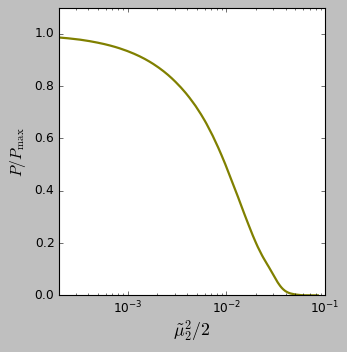

In [48]:
from matplotlib.ticker import ScalarFormatter

output_folder = "output3/run_info"

# Load the MCMC samples
samples = loadMCSamples(output_folder)

g = plots.get_single_plotter(width_inch=4.5, ratio=1)
g.settings.prob_y_ticks = [0.1,0.3,0.6,0.9]
g.settings.prob_label = r'$P/P_{\rm max}$'
g.plot_1d([samples],"mu2",lims=[5e-3, 0.05],ls=['-'],lws=2,colors=['olive'])
#g.add_legend(['2020-2021','2012-2013'], legend_loc='upper right')
g.settings.scaling_factor = 1.



# # Access the underlying matplotlib axes to modify ticks
ax = g.fig.axes[0]  # Get the current axes
ax.set_xscale('log')

current_ticks = ax.get_xticks() 



print(current_ticks)



#ax.set_xlabel(r'$\mu_2[\rm \ GeV^{-1} ]$', fontsize=16)
ax.set_xlabel(r'$\tilde{\mu}^2_2/2$', fontsize=16)

#log_ticks = [1.8e-4, 1.8e-2]


# Compute labels: √(2e-7/0.036 × x) for each tick
#new_labels = [f"{1e-7*np.sqrt(2/ 0.036 * x):.1e}" for x in log_ticks]
new_labels = [f"{np.sqrt(2/ 0.036 * x):.1e}" for x in current_ticks]


#new_labels = [r'$10^{-8}$', r'$ 10^{-7}$']





# formatter = ScalarFormatter(useMathText=True)
# formatter.set_scientific(True)
# #formatter.set_powerlimits((0, 0))  # Always use sci notation
# ax.xaxis.set_major_formatter(formatter)

# Apply ticks and labels
#ax.set_xticks(log_ticks)
ax.set_xticks(current_ticks)
ax.set_xlim(2e-4,1e-1)
#ax.set_xlim(2.7e-2,0.1)
#ax.set_ylim(0,0.1)


new_labels = [r'$2.4\times 10^{-8}$',r'$2.4\times 10^{-8}$', r'$ 7.5\times 10^{-8}$', r'$ 2.4\times 10^{-7}$',r'$ 2.4\times 10^{-7}$']
#ax.set_xticklabels(new_labels, fontsize=15)


# new_ticks = np.sqrt(2e-7/0.036 * current_ticks)
# ax.set_xticks(current_ticks)
# ax.set_xticklabels([f"{val:.2e}" for val in new_ticks])


# #ax.ticklabel_format(axis='x', style='sci', scilimits=(0, 0), useMathText=True)
# # Optionally rotate x-tick labels if needed
# #ax.tick_params(axis='x', rotation=45)  

# Adjust layout to prevent label cutoff
g.fig.tight_layout()


# #g.settings.axes_fontsize=12
g.export('posteriors_tot2.pdf')

In [ ]:
#best fit and covariance matrix and errors
mean   = gd_sample.getMeans()
covmat = gd_sample.getCovMat().matrix[:, :]
print("Mean:")
print(mean)
print("Covariance matrix:")
print(covmat)
print('####################')

stats = gd_sample.getMargeStats()
lims1 = stats.parWithName('t12').limits
lims2 = stats.parWithName('mum2').limits
lims3 = stats.parWithName('m12').limits
lims4 = stats.parWithName('delta').limits

for conf, lim1, lim2, lim3, lim4 in zip(gd_sample.contours, lims1,lims2,lims3,lims4):
    print('t12 %s%% lower: %.1f upper: %.1f (%s)'%(conf, lim1.lower, lim1.upper, lim1.limitType()))
    print('mum2 %s%% lower: %.2f upper: %.2f (%s)'%(conf, lim2.lower, lim2.upper, lim2.limitType()))
    print('m12 %s%% lower: %.2f upper: %.2f (%s)'%(conf, lim3.lower, lim3.upper, lim3.limitType()))
    print('delta %s%% lower: %.2f upper: %.2f (%s)'%(conf, lim3.lower, lim3.upper, lim3.limitType()))
    print('####################')

In [59]:
chi2_samp_hi = np.loadtxt('output8_9/run_info.1.txt')
chi2_samp_lo = np.loadtxt('output8_91/run_info.1.txt')
chi2_samp_me = np.loadtxt('output8_7/run_info.1.txt')


chi2_samp = np.loadtxt('output10_1/run_info.1.txt')
print(chi2_samp_hi.shape)
print(chi2_samp_lo.shape)
print(chi2_samp.shape)


print(np.min(chi2_samp[:,1]))
print(np.min(chi2_samp_hi[:,1]))
print(np.min(chi2_samp_lo[:,1]))

(3481, 14)
(4849, 14)
(1252, 11)
-4.3089522
410.57077
415.12223


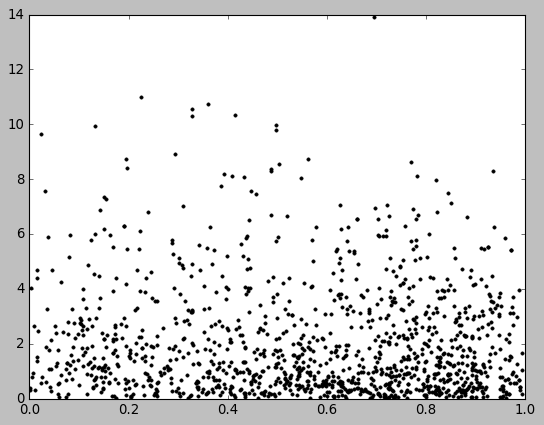

In [67]:
cond = (chi2_samp_hi[:,9] >= 1) & (chi2_samp_hi[:,9] <= 7)
cond_lo = (chi2_samp_lo[:,9] >= 0.7) & (chi2_samp_lo[:,9] <= 3)

plt.rcParams['axes.formatter.useoffset'] = False
#plt.ylim(410,430)

#plt.plot(2 * chi2_samp_hi[cond,9] * 1.31 * 1e-2, chi2_samp_hi[cond,1],'b.')
#plt.plot(2 * chi2_samp_lo[:,9] * 1.31 * 1e-2, chi2_samp_lo[:,1],'b.')


plt.plot(chi2_samp[:,5], chi2_samp[:,9] ,'k.')
#plt.plot(chi2_samp_me[:,4], chi2_samp_me[:,1] ,'r.')
#plt.plot(chi2_samp_hi[cond,4], chi2_samp_hi[cond,1] ,'b.')
#plt.plot(chi2_samp_lo[cond_lo,4], chi2_samp_lo[cond_lo,1] ,'g.')

In [ ]:
a = []
for i in range(2,10):
    print(chi2_samp[:,i][chi2_samp[:,1] == np.min(chi2_samp[:,1])])
    #a.append(chi2_samp_lo[cond_lo,i][chi2_samp_lo[cond_lo,1] == np.min(chi2_samp_lo[cond_lo,1])][0])

#print(LogLikelihood(a[0], a[1], a[7], a[2], a[3], a[4], a[5], a[6]))

[0.27746395]
[7.5834488]
[0.11025405]
[0.72821955]
[0.74261607]
[2.2422824]
[0.5407439]
[0.84253096]


In [43]:
np.savetxt('./Data/best_fit_8_91.txt',np.array(a).T)

In [ ]:
#the range between 0.7 to 3 must be probed

print(2 * 0.7 * 1.31 * 1e-2)

0.01834
